In [3]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import time
import copy
import os
from torchvision.transforms import AutoAugment, AutoAugmentPolicy, RandAugment, TrivialAugmentWide
# =========================
# 0. Config
# =========================
data_dir = "/kaggle/input/data-snake/kaggle/working/data"   # Cấu trúc thư mục: data/train, data/val
num_classes = 124
batch_size = 32
num_epochs = 30
lr = 5e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# =========================
# 1. Data Augmentation
# =========================
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), val_transform)
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# =========================
# 2. CutMix
# =========================
def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size, _, h, w = x.size()
    index = torch.randperm(batch_size)

    cut_rat = np.sqrt(1. - lam)
    cut_w = int(w * cut_rat)
    cut_h = int(h * cut_rat)

    # Random center
    cx = np.random.randint(w)
    cy = np.random.randint(h)

    bbx1 = np.clip(cx - cut_w // 2, 0, w)
    bby1 = np.clip(cy - cut_h // 2, 0, h)
    bbx2 = np.clip(cx + cut_w // 2, 0, w)
    bby2 = np.clip(cy + cut_h // 2, 0, h)

    x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    y_a, y_b = y, y[index]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (w * h))
    return x, y_a, y_b, lam
# for inputs, labels in dataloaders['train']:
#     inputs, labels = inputs.to(device), labels.to(device)
    
#     # === CutMix ===
#     inputs, targets_a, targets_b, lam = cutmix_data(inputs, labels, alpha=1.0)
    
#     optimizer.zero_grad()
#     outputs = model(inputs)
#     loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
#     loss.backward()
#     optimizer.step()
# =========================
# 3. Model
# =========================
model = models.swin_s(weights="IMAGENET1K_V1")  # pretrained Swin-Small
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)

# =========================
# 4. Loss, Optimizer, Scheduler
# =========================
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# ================================
# 5. Checkpoint helpers
# ================================
def save_checkpoint(model, optimizer, scheduler, epoch, history, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'history': history
    }
    torch.save(checkpoint, path)
    print(f"✅ Saved checkpoint at {path}")

def load_checkpoint(model, optimizer, scheduler, path, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    history = checkpoint['history']
    print(f"✅ Loaded checkpoint from {path} (epoch {epoch})")
    return model, optimizer, scheduler, epoch, history

# =========================
# 6. Training Loop
# =========================
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, use_cutmix=True, alpha=1.0):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    # === Áp dụng CutMix chỉ trong train phase ===
                    if phase == 'train' and use_cutmix:
                        inputs, targets_a, targets_b, lam = cutmix_data(inputs, labels, alpha)
                        outputs = model(inputs)
                        loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double().item() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Lưu history
            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)
            
            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                save_checkpoint(model, optimizer, scheduler, epoch+1, history, "/kaggle/working/best_checkpoint.pth")
        
        # Lưu checkpoint mỗi 5 epoch
        if (epoch + 1) % 5 == 0:
            save_checkpoint(model, optimizer, scheduler, epoch+1, history, f"/kaggle/working/checkpoint_epoch{epoch+1}.pth")
        
        print()
    
    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history

# =========================
# 7. Run Training
# =========================
model, history = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs,
    use_cutmix=True,  # Bật CutMix
    alpha=1.0         # Hệ số trộn
)

# Save final best model
torch.save(model.state_dict(), "/kaggle/working/swin_tiny_best.pth")
print("✅ Training complete and best model saved.")


Downloading: "https://download.pytorch.org/models/swin_s-5e29d889.pth" to /root/.cache/torch/hub/checkpoints/swin_s-5e29d889.pth
100%|██████████| 190M/190M [00:01<00:00, 187MB/s]  


Epoch 1/30
--------------------
train Loss: 3.3310 Acc: 0.3566
val Loss: 1.6700 Acc: 0.7413
✅ Saved checkpoint at /kaggle/working/best_checkpoint.pth

Epoch 2/30
--------------------
train Loss: 2.4335 Acc: 0.5731
val Loss: 1.3816 Acc: 0.8219
✅ Saved checkpoint at /kaggle/working/best_checkpoint.pth

Epoch 3/30
--------------------
train Loss: 2.1738 Acc: 0.6281
val Loss: 1.2743 Acc: 0.8519
✅ Saved checkpoint at /kaggle/working/best_checkpoint.pth

Epoch 4/30
--------------------
train Loss: 2.0181 Acc: 0.6585
val Loss: 1.1960 Acc: 0.8787
✅ Saved checkpoint at /kaggle/working/best_checkpoint.pth

Epoch 5/30
--------------------
train Loss: 1.9164 Acc: 0.6755
val Loss: 1.1618 Acc: 0.8859
✅ Saved checkpoint at /kaggle/working/best_checkpoint.pth
✅ Saved checkpoint at /kaggle/working/checkpoint_epoch5.pth

Epoch 6/30
--------------------
train Loss: 1.8301 Acc: 0.7025
val Loss: 1.1209 Acc: 0.8986
✅ Saved checkpoint at /kaggle/working/best_checkpoint.pth

Epoch 7/30
--------------------
tr

In [4]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np


# =========================
# 7. Evaluation on Test Set
# =========================
# Load lại test dataset
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Lấy mapping index -> class name
class_names = test_dataset.classes
num_classes = len(class_names)

# Load best model đã save
model = models.swin_s(weights=None)
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)

# --- Load checkpoint ---
checkpoint_path = "/kaggle/working/best_checkpoint.pth"  # thay bằng checkpoint bạn muốn
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Cách thuần tuý
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# =========================
# 8. Tính accuracy
# =========================
overall_acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {overall_acc:.4f}")

# =========================
# 9. Accuracy từng class
# =========================
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

print("\nAccuracy theo từng class:")
for i, class_name in enumerate(class_names):
    idx = (all_labels == i)
    if np.sum(idx) == 0:
        acc = 0.0
    else:
        acc = np.mean(all_preds[idx] == all_labels[idx])
    correct = np.sum(all_preds[idx] == all_labels[idx])
    total = np.sum(idx)
    print(f"{class_name:25s}  Acc: {acc:.4f}  ({correct}/{total})")

# =========================
# 10. Classification Report (optional)
# =========================
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


Test Accuracy: 0.9372

Accuracy theo từng class:
Achalinus_rufescens        Acc: 1.0000  (13/13)
Achalinus_spinalis         Acc: 0.9286  (13/14)
Acrochordus_granulatus     Acc: 0.9302  (40/43)
Acrochordus_javanicus      Acc: 1.0000  (8/8)
Ahaetulla_fusca            Acc: 1.0000  (27/27)
Ahaetulla_prasina          Acc: 1.0000  (20/20)
Ahaetulla_rufusoculara     Acc: 1.0000  (9/9)
Amphiesma_stolatum         Acc: 0.9605  (73/76)
Blue-lipped_sea_krait      Acc: 0.9756  (80/82)
Boiga_cyanea               Acc: 0.9620  (76/79)
Boiga_guangxiensis         Acc: 0.8750  (7/8)
Boiga_jaspidea             Acc: 0.9756  (40/41)
Boiga_kraepelini           Acc: 0.9403  (63/67)
Boiga_multomaculata        Acc: 0.9900  (99/100)
Boiga_siamensis            Acc: 0.9677  (30/31)
Bungarus_candidus          Acc: 0.9155  (65/71)
Bungarus_fasciatus         Acc: 1.0000  (86/86)
Calamaria_septentrionalis  Acc: 0.7727  (17/22)
Calliophis_maculiceps      Acc: 1.0000  (18/18)
Calloselasma_rhodostoma    Acc: 0.9804  (10

🏆 Best Validation Accuracy: 0.9432 (Epoch 30)


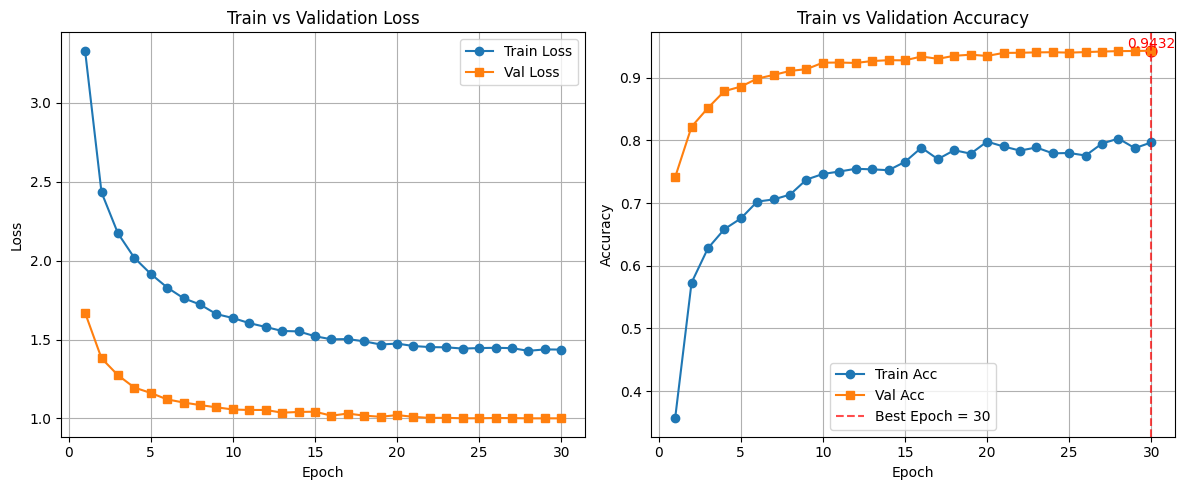

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# 1. Load checkpoint
# =========================
checkpoint_path = "/kaggle/working/best_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
history = checkpoint['history']

# =========================
# 2. Tạo biến epoch & tìm best acc
# =========================
train_acc = history["train_acc"]
val_acc = history["val_acc"]
train_loss = history["train_loss"]
val_loss = history["val_loss"]

epochs = range(1, len(train_acc) + 1)
best_val_acc = max(val_acc)
best_epoch = np.argmax(val_acc) + 1

print(f"🏆 Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")

# =========================
# 3. Vẽ Loss và Accuracy
# =========================
plt.figure(figsize=(12,5))

# --- Loss ---
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'o-', label="Train Loss")
plt.plot(epochs, val_loss, 's-', label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)

# --- Accuracy ---
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, 'o-', label="Train Acc")
plt.plot(epochs, val_acc, 's-', label="Val Acc")
plt.axvline(best_epoch, color='r', linestyle='--', alpha=0.7, label=f"Best Epoch = {best_epoch}")
plt.scatter(best_epoch, best_val_acc, color='red', s=60)
plt.text(best_epoch, best_val_acc + 0.005, f"{best_val_acc:.4f}", color='red', ha='center')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [6]:
print("\n⚠️ Các class dưới 70% accuracy:")
for i, class_name in enumerate(class_names):
    idx = (all_labels == i)
    if np.sum(idx) == 0:
        acc = 0.0
        correct, total = 0, 0
    else:
        acc = np.mean(all_preds[idx] == all_labels[idx])
        correct = np.sum(all_preds[idx] == all_labels[idx])
        total = np.sum(idx)

    if acc < 0.7:  # dưới 70%
        print(f"{class_name:25s}  Acc: {acc:.4f}  ({correct}/{total})")



⚠️ Các class dưới 70% accuracy:
Erpeton_tentaculatum       Acc: 0.4444  (4/9)
Lycodon_chapaensis         Acc: 0.6000  (6/10)
Naja_fuxi                  Acc: 0.6000  (6/10)
Pareas_berdmorei           Acc: 0.6071  (17/28)
Pareas_hamptoni            Acc: 0.2857  (2/7)
Ptyas_mucosa               Acc: 0.6667  (10/15)
Sinomicrurus_peinani       Acc: 0.5000  (4/8)


In [ ]:
import torch
from torchvision import transforms, datasets, models
from PIL import Image
import requests
from io import BytesIO
import os

# =====================
# 1. Cấu hình
# =====================
num_classes = 124
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =====================
# 2. Load model
# =====================
model = models.swin_s(weights=None)
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)

# --- Load checkpoint ---
checkpoint_path = "/kaggle/working/best_checkpoint.pth"  # thay bằng checkpoint bạn muốn
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# =====================
# 3. Transform
# =====================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# =====================
# 4. Lấy class_names từ folder train
# =====================
data_dir = "/kaggle/input/data-snake/kaggle/working/data"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'))
class_names = train_dataset.classes

# =====================
# 5. Hàm dự đoán
# =====================
def predict_from_url(url, class_names):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()

    print(f"Predicted class: {class_names[pred_idx]} (prob = {probs[0][pred_idx]:.4f})")
    return class_names[pred_idx]

# =====================
# 6. Ví dụ sử dụng
# =====================
url = "https://vietnamsnakes.com/storage/snakes/species/46/1748341202_0.jpg"
predict_from_url(url, class_names)


Predicted class: Bungarus_fasciatus (prob = 0.9233)
